<a href="https://colab.research.google.com/github/johnjkiran/TSAI/blob/master/S10/S10_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/S10')

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
from importlib.machinery import SourceFileLoader
from os.path import join
config = SourceFileLoader('config',join('/content/drive/My Drive/Colab Notebooks/S10','config.py')).load_module()
from config import model_config
utills = SourceFileLoader('utills',join('/content/drive/My Drive/Colab Notebooks/S10','utills.py')).load_module()
from utills import *
args = model_config()
args.print_config()
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 128,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}
CUDA Available


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
airplane   dog  deer  deer truck


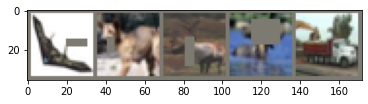

In [5]:
# !pip install albumentations==0.4.5
data_transform = SourceFileLoader('data_transform',join('/content/drive/My Drive/Colab Notebooks/S10','data_transform.py')).load_module()
data_engine = SourceFileLoader('data_engine',join('/content/drive/My Drive/Colab Notebooks/S10','data_engine.py')).load_module()
from data_engine import DataEngine
data = DataEngine(args)

# Training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:5]))
print(' '.join('%5s' % data.classes[labels[j]] for j in range(5)))


In [20]:
resnet = SourceFileLoader('resnet',join('/content/drive/My Drive/Colab Notebooks/S10','resnet.py')).load_module()
from resnet import ResNet18
device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

LR Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


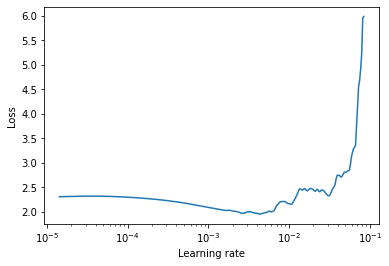

In [23]:
from lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum)
lr_finder = LRFinder(model,optimizer=optimizer,criterion=criterion,device=device)
lr_finder.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-5, end_lr=1,
                     num_iter=len(data.train_loader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [24]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Lowest Loss %s \n Best Learning Rate: %s" % (best_loss,best_lr))
args.lr = best_lr

Lowest Loss 1.9513268998616657 
 Best Learning Rate: 0.0044366873309786125


In [0]:
train = SourceFileLoader('train',join('/content/drive/My Drive/Colab Notebooks/S10','train.py')).load_module()
test = SourceFileLoader('test',join('/content/drive/My Drive/Colab Notebooks/S10','test.py')).load_module()

In [33]:
from train import train
from test import test
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                              verbose=True, min_lr=1e-5)

def model_run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
      scheduler.step(test_losses[-1])
  return train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs = model_run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=459.00921630859375 L1_loss=109101.078125 Loss=2.053227186203003 Batch_id=390 Accuracy=39.84: 100%|██████████| 391/391 [00:37<00:00, 10.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0107, Accuracy: 5321/10000 (53.21%)

EPOCH: 2


L2_loss=459.01483154296875 L1_loss=108711.40625 Loss=1.9348783493041992 Batch_id=390 Accuracy=54.33: 100%|██████████| 391/391 [00:38<00:00, 10.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0083, Accuracy: 6214/10000 (62.14%)

EPOCH: 3


L2_loss=459.0697937011719 L1_loss=108345.1015625 Loss=1.7768332958221436 Batch_id=390 Accuracy=60.80: 100%|██████████| 391/391 [00:38<00:00, 10.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0081, Accuracy: 6502/10000 (65.02%)

EPOCH: 4


L2_loss=459.056396484375 L1_loss=107981.2421875 Loss=1.6573867797851562 Batch_id=390 Accuracy=65.06: 100%|██████████| 391/391 [00:38<00:00, 10.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0061, Accuracy: 7288/10000 (72.88%)

EPOCH: 5


L2_loss=459.031494140625 L1_loss=107621.828125 Loss=1.7517955303192139 Batch_id=390 Accuracy=68.47: 100%|██████████| 391/391 [00:38<00:00, 10.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0065, Accuracy: 7146/10000 (71.46%)

EPOCH: 6


L2_loss=458.98919677734375 L1_loss=107269.1328125 Loss=1.5895493030548096 Batch_id=390 Accuracy=71.12: 100%|██████████| 391/391 [00:38<00:00, 10.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7635/10000 (76.35%)

EPOCH: 7


L2_loss=458.8724060058594 L1_loss=106912.4453125 Loss=1.6166528463363647 Batch_id=390 Accuracy=73.18: 100%|██████████| 391/391 [00:38<00:00, 10.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7617/10000 (76.17%)

EPOCH: 8


L2_loss=458.7823791503906 L1_loss=106561.3828125 Loss=1.3936368227005005 Batch_id=390 Accuracy=75.09: 100%|██████████| 391/391 [00:38<00:00, 10.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0045, Accuracy: 8009/10000 (80.09%)

EPOCH: 9


L2_loss=458.6062316894531 L1_loss=106215.21875 Loss=1.660151481628418 Batch_id=390 Accuracy=76.20: 100%|██████████| 391/391 [00:38<00:00, 10.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0049, Accuracy: 7829/10000 (78.29%)

EPOCH: 10


L2_loss=458.4438781738281 L1_loss=105871.390625 Loss=1.3372548818588257 Batch_id=390 Accuracy=77.40: 100%|██████████| 391/391 [00:38<00:00, 10.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0044, Accuracy: 8134/10000 (81.34%)

EPOCH: 11


L2_loss=458.2658386230469 L1_loss=105535.0625 Loss=1.4544874429702759 Batch_id=390 Accuracy=78.47: 100%|██████████| 391/391 [00:37<00:00, 10.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8348/10000 (83.48%)

EPOCH: 12


L2_loss=458.0802307128906 L1_loss=105205.65625 Loss=1.2626140117645264 Batch_id=390 Accuracy=79.77: 100%|██████████| 391/391 [00:38<00:00, 10.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8366/10000 (83.66%)

EPOCH: 13


L2_loss=457.86151123046875 L1_loss=104879.2890625 Loss=1.195677638053894 Batch_id=390 Accuracy=80.48: 100%|██████████| 391/391 [00:38<00:00, 10.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0040, Accuracy: 8356/10000 (83.56%)

EPOCH: 14


L2_loss=457.6665954589844 L1_loss=104560.5625 Loss=1.5846502780914307 Batch_id=390 Accuracy=81.20: 100%|██████████| 391/391 [00:38<00:00, 10.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8332/10000 (83.32%)

EPOCH: 15


L2_loss=457.4215393066406 L1_loss=104246.078125 Loss=1.264893889427185 Batch_id=390 Accuracy=81.71: 100%|██████████| 391/391 [00:38<00:00, 10.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8385/10000 (83.85%)

EPOCH: 16


L2_loss=457.2032165527344 L1_loss=103940.640625 Loss=1.2082939147949219 Batch_id=390 Accuracy=82.57: 100%|██████████| 391/391 [00:38<00:00, 10.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0048, Accuracy: 8129/10000 (81.29%)

EPOCH: 17


L2_loss=456.95330810546875 L1_loss=103636.4453125 Loss=1.2651015520095825 Batch_id=390 Accuracy=82.99: 100%|██████████| 391/391 [00:38<00:00, 10.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0034, Accuracy: 8520/10000 (85.20%)

EPOCH: 18


L2_loss=456.71099853515625 L1_loss=103332.03125 Loss=1.0704371929168701 Batch_id=390 Accuracy=83.52: 100%|██████████| 391/391 [00:38<00:00, 10.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0037, Accuracy: 8456/10000 (84.56%)

EPOCH: 19


L2_loss=456.4471435546875 L1_loss=103037.6015625 Loss=1.043393850326538 Batch_id=390 Accuracy=84.19: 100%|██████████| 391/391 [00:38<00:00, 10.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8540/10000 (85.40%)

EPOCH: 20


L2_loss=456.16046142578125 L1_loss=102739.390625 Loss=1.2054204940795898 Batch_id=390 Accuracy=84.52: 100%|██████████| 391/391 [00:38<00:00, 10.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0033, Accuracy: 8656/10000 (86.56%)

EPOCH: 21


L2_loss=455.8629455566406 L1_loss=102447.6875 Loss=1.1037267446517944 Batch_id=390 Accuracy=85.05: 100%|██████████| 391/391 [00:38<00:00, 10.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8560/10000 (85.60%)

EPOCH: 22


L2_loss=455.6040954589844 L1_loss=102170.328125 Loss=1.0897849798202515 Batch_id=390 Accuracy=85.38: 100%|██████████| 391/391 [00:38<00:00, 10.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0034, Accuracy: 8620/10000 (86.20%)

EPOCH: 23


L2_loss=455.28973388671875 L1_loss=101891.8203125 Loss=1.0889167785644531 Batch_id=390 Accuracy=85.56: 100%|██████████| 391/391 [00:38<00:00, 10.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8631/10000 (86.31%)

EPOCH: 24


L2_loss=455.0054626464844 L1_loss=101613.765625 Loss=1.3166751861572266 Batch_id=390 Accuracy=86.13: 100%|██████████| 391/391 [00:38<00:00, 10.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8697/10000 (86.97%)

EPOCH: 25


L2_loss=454.6818542480469 L1_loss=101339.25 Loss=1.1850340366363525 Batch_id=390 Accuracy=86.77: 100%|██████████| 391/391 [00:38<00:00, 10.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0033, Accuracy: 8649/10000 (86.49%)

EPOCH: 26


L2_loss=454.3800048828125 L1_loss=101067.9296875 Loss=1.0564385652542114 Batch_id=390 Accuracy=86.84: 100%|██████████| 391/391 [00:38<00:00, 10.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8720/10000 (87.20%)

EPOCH: 27


L2_loss=454.0772399902344 L1_loss=100803.4375 Loss=1.0984553098678589 Batch_id=390 Accuracy=87.29: 100%|██████████| 391/391 [00:38<00:00, 10.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0034, Accuracy: 8668/10000 (86.68%)

EPOCH: 28


L2_loss=453.7423095703125 L1_loss=100541.5234375 Loss=1.1220307350158691 Batch_id=390 Accuracy=87.65: 100%|██████████| 391/391 [00:38<00:00, 10.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0033, Accuracy: 8656/10000 (86.56%)

EPOCH: 29


L2_loss=453.41522216796875 L1_loss=100274.1640625 Loss=1.2011263370513916 Batch_id=390 Accuracy=87.95: 100%|██████████| 391/391 [00:38<00:00, 10.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0033, Accuracy: 8710/10000 (87.10%)

EPOCH: 30


L2_loss=453.0872497558594 L1_loss=100025.6328125 Loss=1.0381221771240234 Batch_id=390 Accuracy=87.87: 100%|██████████| 391/391 [00:38<00:00, 10.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0034, Accuracy: 8748/10000 (87.48%)

Epoch    30: reducing learning rate of group 0 to 4.4367e-04.
EPOCH: 31


L2_loss=452.9662170410156 L1_loss=99954.359375 Loss=0.9715754985809326 Batch_id=390 Accuracy=90.94: 100%|██████████| 391/391 [00:38<00:00, 10.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 95 %
Accuracy of automobile : 95 %
Accuracy of  bird : 85 %
Accuracy of   cat : 66 %
Accuracy of  deer : 93 %
Accuracy of   dog : 82 %
Accuracy of  frog : 87 %
Accuracy of horse : 96 %
Accuracy of  ship : 94 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0024, Accuracy: 9060/10000 (90.60%)

EPOCH: 32


L2_loss=452.8515319824219 L1_loss=99883.9921875 Loss=1.0820027589797974 Batch_id=390 Accuracy=91.68: 100%|██████████| 391/391 [00:38<00:00, 10.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 96 %
Accuracy of automobile : 93 %
Accuracy of  bird : 87 %
Accuracy of   cat : 80 %
Accuracy of  deer : 83 %
Accuracy of   dog : 74 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0023, Accuracy: 9086/10000 (90.86%)

EPOCH: 33


L2_loss=452.73858642578125 L1_loss=99814.6171875 Loss=0.9458271265029907 Batch_id=390 Accuracy=92.24: 100%|██████████| 391/391 [00:38<00:00, 10.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 89 %
Accuracy of automobile : 97 %
Accuracy of  bird : 78 %
Accuracy of   cat : 80 %
Accuracy of  deer : 100 %
Accuracy of   dog : 82 %
Accuracy of  frog : 90 %
Accuracy of horse : 100 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0023, Accuracy: 9082/10000 (90.82%)

EPOCH: 34


L2_loss=452.6260070800781 L1_loss=99745.8515625 Loss=0.9001368284225464 Batch_id=390 Accuracy=92.43: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 86 %
Accuracy of automobile : 97 %
Accuracy of  bird : 88 %
Accuracy of   cat : 75 %
Accuracy of  deer : 91 %
Accuracy of   dog : 83 %
Accuracy of  frog : 92 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0023, Accuracy: 9103/10000 (91.03%)

EPOCH: 35


L2_loss=452.5137023925781 L1_loss=99677.625 Loss=0.9028149843215942 Batch_id=390 Accuracy=92.51: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 91 %
Accuracy of automobile : 100 %
Accuracy of  bird : 76 %
Accuracy of   cat : 89 %
Accuracy of  deer : 92 %
Accuracy of   dog : 91 %
Accuracy of  frog : 94 %
Accuracy of horse : 83 %
Accuracy of  ship : 95 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0023, Accuracy: 9089/10000 (90.89%)

EPOCH: 36


L2_loss=452.4007873535156 L1_loss=99609.3515625 Loss=1.0032415390014648 Batch_id=390 Accuracy=92.56: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 96 %
Accuracy of automobile : 94 %
Accuracy of  bird : 88 %
Accuracy of   cat : 96 %
Accuracy of  deer : 96 %
Accuracy of   dog : 86 %
Accuracy of  frog : 93 %
Accuracy of horse : 94 %
Accuracy of  ship : 100 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0023, Accuracy: 9094/10000 (90.94%)

EPOCH: 37


L2_loss=452.29193115234375 L1_loss=99541.40625 Loss=0.9780439138412476 Batch_id=390 Accuracy=93.03: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 92 %
Accuracy of automobile : 100 %
Accuracy of  bird : 92 %
Accuracy of   cat : 68 %
Accuracy of  deer : 90 %
Accuracy of   dog : 82 %
Accuracy of  frog : 100 %
Accuracy of horse : 96 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0023, Accuracy: 9104/10000 (91.04%)

EPOCH: 38


L2_loss=452.183837890625 L1_loss=99474.03125 Loss=0.8841105699539185 Batch_id=390 Accuracy=92.90: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 100 %
Accuracy of automobile : 92 %
Accuracy of  bird : 96 %
Accuracy of   cat : 82 %
Accuracy of  deer : 80 %
Accuracy of   dog : 90 %
Accuracy of  frog : 95 %
Accuracy of horse : 95 %
Accuracy of  ship : 96 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0023, Accuracy: 9108/10000 (91.08%)

EPOCH: 39


L2_loss=452.07623291015625 L1_loss=99407.109375 Loss=0.8935767412185669 Batch_id=390 Accuracy=93.08: 100%|██████████| 391/391 [00:40<00:00,  9.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 93 %
Accuracy of automobile : 93 %
Accuracy of  bird : 87 %
Accuracy of   cat : 63 %
Accuracy of  deer : 87 %
Accuracy of   dog : 72 %
Accuracy of  frog : 95 %
Accuracy of horse : 88 %
Accuracy of  ship : 95 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0023, Accuracy: 9098/10000 (90.98%)

EPOCH: 40


L2_loss=451.9729309082031 L1_loss=99340.5703125 Loss=0.9453893899917603 Batch_id=390 Accuracy=93.23: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 94 %
Accuracy of automobile : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 78 %
Accuracy of  deer : 85 %
Accuracy of   dog : 85 %
Accuracy of  frog : 92 %
Accuracy of horse : 94 %
Accuracy of  ship : 96 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0023, Accuracy: 9115/10000 (91.15%)

EPOCH: 41


L2_loss=451.86895751953125 L1_loss=99274.03125 Loss=0.9159564971923828 Batch_id=390 Accuracy=93.46: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 100 %
Accuracy of automobile : 92 %
Accuracy of  bird : 88 %
Accuracy of   cat : 77 %
Accuracy of  deer : 76 %
Accuracy of   dog : 93 %
Accuracy of  frog : 100 %
Accuracy of horse : 90 %
Accuracy of  ship : 90 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0023, Accuracy: 9113/10000 (91.13%)

EPOCH: 42


L2_loss=451.7654724121094 L1_loss=99207.4453125 Loss=1.0317168235778809 Batch_id=390 Accuracy=93.37: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 85 %
Accuracy of automobile : 93 %
Accuracy of  bird : 78 %
Accuracy of   cat : 84 %
Accuracy of  deer : 96 %
Accuracy of   dog : 88 %
Accuracy of  frog : 91 %
Accuracy of horse : 91 %
Accuracy of  ship : 90 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0023, Accuracy: 9117/10000 (91.17%)

Epoch    42: reducing learning rate of group 0 to 4.4367e-05.
EPOCH: 43


L2_loss=451.7512512207031 L1_loss=99200.0625 Loss=0.9933602809906006 Batch_id=390 Accuracy=93.61: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 91 %
Accuracy of automobile : 92 %
Accuracy of  bird : 89 %
Accuracy of   cat : 71 %
Accuracy of  deer : 94 %
Accuracy of   dog : 67 %
Accuracy of  frog : 83 %
Accuracy of horse : 95 %
Accuracy of  ship : 96 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0023, Accuracy: 9122/10000 (91.22%)

EPOCH: 44


L2_loss=451.7383117675781 L1_loss=99192.8828125 Loss=0.8727260231971741 Batch_id=390 Accuracy=93.72: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 89 %
Accuracy of automobile : 100 %
Accuracy of  bird : 90 %
Accuracy of   cat : 70 %
Accuracy of  deer : 86 %
Accuracy of   dog : 89 %
Accuracy of  frog : 91 %
Accuracy of horse : 87 %
Accuracy of  ship : 92 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0022, Accuracy: 9134/10000 (91.34%)

EPOCH: 45


L2_loss=451.7254943847656 L1_loss=99185.7109375 Loss=0.960304856300354 Batch_id=390 Accuracy=93.66: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 95 %
Accuracy of automobile : 97 %
Accuracy of  bird : 87 %
Accuracy of   cat : 90 %
Accuracy of  deer : 95 %
Accuracy of   dog : 91 %
Accuracy of  frog : 97 %
Accuracy of horse : 100 %
Accuracy of  ship : 91 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0022, Accuracy: 9141/10000 (91.41%)

EPOCH: 46


L2_loss=451.7132873535156 L1_loss=99178.515625 Loss=0.9487357139587402 Batch_id=390 Accuracy=93.62: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 79 %
Accuracy of automobile : 90 %
Accuracy of  bird : 86 %
Accuracy of   cat : 90 %
Accuracy of  deer : 84 %
Accuracy of   dog : 74 %
Accuracy of  frog : 95 %
Accuracy of horse : 92 %
Accuracy of  ship : 91 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0022, Accuracy: 9143/10000 (91.43%)

EPOCH: 47


L2_loss=451.70159912109375 L1_loss=99171.3515625 Loss=0.8952677249908447 Batch_id=390 Accuracy=93.75: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 95 %
Accuracy of automobile : 96 %
Accuracy of  bird : 80 %
Accuracy of   cat : 90 %
Accuracy of  deer : 87 %
Accuracy of   dog : 85 %
Accuracy of  frog : 96 %
Accuracy of horse : 95 %
Accuracy of  ship : 93 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0022, Accuracy: 9134/10000 (91.34%)

EPOCH: 48


L2_loss=451.6905212402344 L1_loss=99164.1875 Loss=0.9058768153190613 Batch_id=390 Accuracy=93.85: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 95 %
Accuracy of automobile : 100 %
Accuracy of  bird : 81 %
Accuracy of   cat : 85 %
Accuracy of  deer : 86 %
Accuracy of   dog : 87 %
Accuracy of  frog : 94 %
Accuracy of horse : 96 %
Accuracy of  ship : 89 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0022, Accuracy: 9136/10000 (91.36%)

EPOCH: 49


L2_loss=451.6789855957031 L1_loss=99157.0390625 Loss=0.8587329983711243 Batch_id=390 Accuracy=93.76: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of airplane : 90 %
Accuracy of automobile : 93 %
Accuracy of  bird : 100 %
Accuracy of   cat : 89 %
Accuracy of  deer : 91 %
Accuracy of   dog : 80 %
Accuracy of  frog : 96 %
Accuracy of horse : 88 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0022, Accuracy: 9127/10000 (91.27%)

EPOCH: 50


L2_loss=451.6676025390625 L1_loss=99149.9140625 Loss=0.8933392763137817 Batch_id=390 Accuracy=93.76: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]



Accuracy of airplane : 97 %
Accuracy of automobile : 100 %
Accuracy of  bird : 96 %
Accuracy of   cat : 76 %
Accuracy of  deer : 90 %
Accuracy of   dog : 94 %
Accuracy of  frog : 90 %
Accuracy of horse : 95 %
Accuracy of  ship : 90 %
Accuracy of truck : 84 %

Test set: Average loss: 0.0023, Accuracy: 9135/10000 (91.35%)



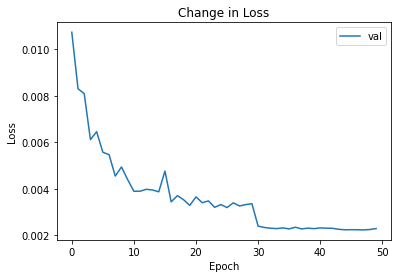

In [34]:
import matplotlib.pyplot as plt
import numpy as np
def plot_graph(data, metric):
    fig, ax = plt.subplots()

    for sub_metric in data.keys():
      ax.plot(data[sub_metric], label=sub_metric)
    
    plt.title(f'Change in %s' % (metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    ax.legend()
    plt.show()

    fig.savefig(f'%s_change.png' % (metric.lower()))

plt_data = {
    "val": test_losses
}
plot_graph(plt_data, "Loss")

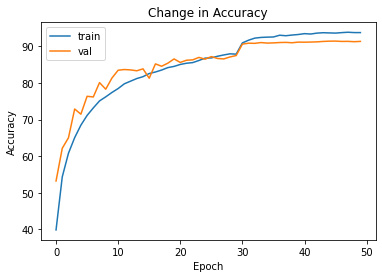

In [35]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

In [0]:
GradCam = SourceFileLoader('GradCam',join('/content/drive/My Drive/Colab Notebooks/S10','GradCam.py')).load_module()
from GradCam import grad_cam
visualize_gradcam = SourceFileLoader('visualize_gradcam',join('/content/drive/My Drive/Colab Notebooks/S10','visualize_gradcam.py')).load_module()
from visualize_gradcam import VisualizeCam

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

In [40]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

AttributeError: ignored